### Things to do
#### General Notes
- `airline_sentiment` and possibly `airline_sentiment_confidence` are target columns (the latter cannot be in traning data)
- Remove instance of `"@airline"` tags from text 

####  How to handle each column
**Numerical Columns**
- `negativereason_confidence` -- fill missing data with 0
- `retweet_count` -- remove, almost 100% is just 0

**Categorical Columns**
- `negativereason` -- one hot encode top K reasons +1 column for "other"
- `airline` -- remove or one hot encode with "other" column
- `airline_sentiment_gold` -- remove, almost 100% missing data
- `name` -- remove, unique data
- `negative_reason_gold` -- remove, almost 100% missing data
- `tweet_location` -- remove or one hot encode with "other" column

**Other Columns**
- `tweet_coord` -- remove, almost 100% missing data
- `user_timezone` -- remove, a lot of missing and correlates with location
- `tweet_created` -- convert to columns: day of year (sin/cos), day of week, time of day (sin/cos)
- `text` -- sklearn.feature_extraction.text -> CountVectorizer (?)


# Stage 1: Data Collection and Preparation

**Goal**: Gather and perform an initial analysis of publicly available datasets containing labeled texts with sentiment (positive, negative, neutral) in both Polish and English.

**Dataset**:
- **E2 - Twitter US Airline Sentiment**:
  - [Link to Dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

**Tasks**:
1. Conduct an initial data exploration (e.g., number of examples, class distribution).
2. Prepare the data for modeling:
   - Handle missing data.
   - Split the data into training and test sets.

---


In [1]:
!pip install pandas scikit-learn nltk

In [2]:
# Stage 1 
import sys
import os

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from src.transformers import *

[nltk_data] Downloading package stopwords to /home/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/michal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/michal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def load_data():
    df = pd.read_csv('data/Tweets.csv')
    df = df.drop(columns=['tweet_id'])

    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df[['airline_sentiment']], random_state=0)

    X_train = df_train.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_train = df_train[['airline_sentiment']]

    X_test = df_test.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_test = df_test[['airline_sentiment']]

    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = load_data()

print(X_train[X_train['text'].str.contains('#', na=False)]['text'].tolist())

print(X_train[X_train['text'].str.contains('http', na=False)].shape[0])


['@SouthwestAir when are you releasing your flights for September? Just found out you fly direct lbb to las! So excited! #tripofalifetime', "@AmericanAir I paid extra $ for my seat &amp; the monitor didn't work from on AA111. How about a refund on the seat? Conf #: MDBEEI, McMullen", '@USAirways forced sections 4 and 5 to check their carry on. would have packed differently to check my bag. Why even allow it? #pissed', '@AmericanAir Would have had to fly real far south, huh? #WinterWeather #Brrr', '@SouthwestAir you are failing! Diverted, stuck and no communication! Make a decision and let us go!!!! 😞😡 flight #4229', "@SouthwestAir what's up with these delays?! Throw some priority boarding my way &amp; I'll forgive you!! 👍 #southwest #southwestairlines", '@SouthwestAir Thank you for having flights going out of Nashville! You guys Rock! #DisneyPrincessHalfMarathon #girlsweekend #bffs', "@VirginAmerica Beats EPS Views, Takes On #SouthwestAir VA LUV - Investor's Business Daily http://t.co/


# Stage 2: Building a Simple Sentiment Analysis Model

**Goal**: Develop a basic classification model without advanced variable transformations.

**Tasks**:

1. **Basic Text Processing**:
   - Convert text to lowercase.
   - Remove punctuation and special characters.
   - Remove stop words.
   - Tokenization.
   
2. **Text Representation**:
   - Use Bag-of-Words (BoW) or TF-IDF to transform text into feature vectors.

3. **Model Training**:
   - Apply simple classifiers, such as:
     - Naive Bayes classifier.
     - Logistic regression.
     - Decision trees.
   - Train the model on the training set.

4. **Model Evaluation**:
   - Test the model on the test set.
   - Calculate metrics: AUC/GINI, accuracy, precision, recall, F1-score.
   - Analyze the confusion matrix.

---

In [6]:
# Stage 2
columns_to_drop = ['retweet_count', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 
                   'name', 'user_timezone', 'negativereason', 'negativereason_confidence']
columns_to_fill_zero = []
columns_to_fill_unknown = ['tweet_location']
columns_to_ohe = ['airline', 'tweet_location']

column_order_after_transform = (
    columns_to_fill_zero
    + columns_to_fill_unknown
    + ["airline", "text", "tweet_created"]
)


def column_idx(c):
    return column_order_after_transform.index(c)

preprocessor = Pipeline(
    steps=[
        ("drop", DropColumnTransformer(columns_to_drop)),
        (
            "fill_missing",
            ColumnTransformer(
                transformers=[
                    (
                        "fill_zero",
                        SimpleImputer(strategy="constant", fill_value=0),
                        columns_to_fill_zero,
                    ),
                    (
                        "fill_other",
                        SimpleImputer(strategy="constant", fill_value="Unknown"),
                        columns_to_fill_unknown,
                    ),
                ],
                remainder="passthrough",
            ),
        ),
        (
            "encode",
            ColumnTransformer(
                transformers=[
                    (
                        "ohe",
                        OneHotEncoder(
                            handle_unknown="infrequent_if_exist",
                            max_categories=3,
                            sparse_output=False,
                        ),
                        list(map(column_idx, columns_to_ohe)),
                    ),
                    (
                        "time",
                        TimeTransformer(),
                        list(map(column_idx, ["tweet_created"])),
                    ),
                    (
                        "text",
                        TextTransformer(),
                        list(map(column_idx, ["text"])),
                    ),
                ],
                remainder="passthrough",
            ),
        ),
    ]
)

X_transformed = preprocessor.fit_transform(X_train)


In [7]:
text_data = X_train["text"].values.reshape(-1, 1)

text_transformer = TextTransformer()
processed_texts = text_transformer.fit_transform(text_data)

for i in range(70):
    print(f"Original: {text_data[i][0]}")
    print(f"Processed: {processed_texts[i]}")

Original: @SouthwestAir when are you releasing your flights for September? Just found out you fly direct lbb to las! So excited! #tripofalifetime
Processed: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 200)>
  Coords	Values
  (0, 65)	0.6631681796343593
  (0, 67)	0.7484704172647375
Original: @USAirways can you help us figure out our correct six digit confirmation number?
Processed: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 200)>
  Coords	Values
  (0, 81)	0.5106657223604006
  (0, 124)	0.6726141145332869
  (0, 181)	0.5355471715327534
Original: @AmericanAir I paid extra $ for my seat &amp; the monitor didn't work from on AA111. How about a refund on the seat? Conf #: MDBEEI, McMullen
Processed: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4 stored elements and shape (1, 200)>
  Coords	Values
  (0, 10)	0.3132024445391034
  (0, 139)	0.41919683095760063
  (0, 146)	0.7619162523

In [8]:
X = preprocessor.fit_transform(X_train)
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 141896 stored elements and shape (13176, 211)>


# Stage 3: Developing an Advanced Sentiment Analysis Model

**Goal**: Build a more advanced model, considering detailed data cleaning, transformations, and the use of advanced modeling techniques.

**Tasks**:

1. **Advanced Data Processing and Cleaning**:
   - Handle emoticons and emojis.
   - Correct spelling errors.
   - Apply stemming or lemmatization.
   - Consider negations in the text (e.g., "not good" vs. "bad").
   - Remove duplicates.
   - Normalize text (e.g., expand abbreviations).

2. **Feature Engineering**:
   - Create additional features such as:
     - N-grams (bigrams, trigrams).
     - Word frequency.
     - Sentiment indicators based on dictionaries.
     - Use word embeddings (e.g., Word2Vec, GloVe).

3. **Advanced Modeling Techniques**:
   - Apply more complex models, such as:
     - Support Vector Machines (SVM).
     - Random Forest.
     - Gradient Boosting (e.g., XGBoost).
     - Neural Networks:
       - Recurrent Neural Networks (RNN, LSTM).
       - Convolutional Neural Networks (CNN).
       - Transformer models (e.g., BERT, RoBERTa).

4. **Hyperparameter Tuning**:
   - Use techniques like Grid Search or Random Search for model optimization.

5. **Model Evaluation**:
   - Use cross-validation for model evaluation.
   - Compare results with the simple model:
     - Did advanced techniques improve the performance?
   - Analyze cases where the model performs better or worse.

---

In [9]:
!pip install yellowbrick torch xgboost seaborn

In [10]:
# Stage 3
import torch
from torch import nn
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy.typing as npt
from torch import optim

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from yellowbrick.classifier import ROCAUC
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [11]:
X_train, y_train, X_test, y_test = load_data()

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

le = LabelEncoder()
y_train_processed = le.fit_transform(y_train)
y_test_processed = le.transform(y_test)

/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### Logistic Regression

Accuracy on training data: 0.7511
Accuracy on test data: 0.7213

Classification report for the test data:
              precision    recall  f1-score   support

    negative       0.77      0.89      0.83       918
     neutral       0.53      0.40      0.46       310
    positive       0.68      0.48      0.56       236

    accuracy                           0.72      1464
   macro avg       0.66      0.59      0.62      1464
weighted avg       0.71      0.72      0.71      1464



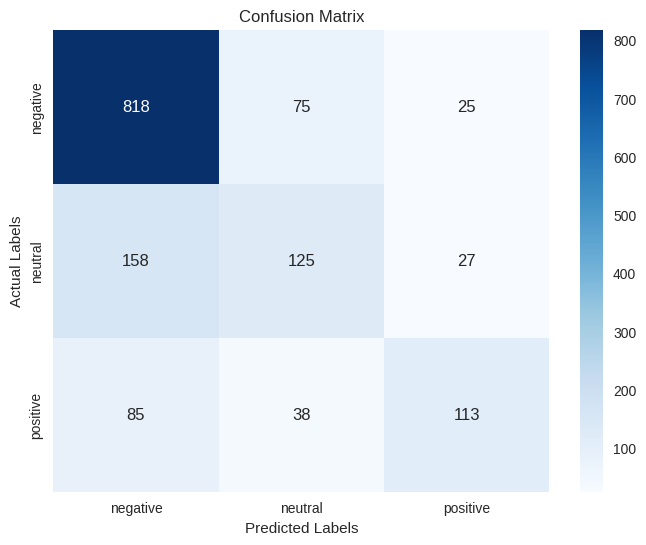

AUC (One-vs-Rest) on test data: 0.8393
f1-score on test data: 0.7058


In [12]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_processed, y_train_processed)

y_train_pred = clf.predict(X_train_processed)
train_accuracy = accuracy_score(y_train_processed, y_train_pred)
print(f"Accuracy on training data: {train_accuracy:.4f}")

y_test_pred = clf.predict(X_test_processed)
test_accuracy = accuracy_score(y_test_processed, y_test_pred)
print(f"Accuracy on test data: {test_accuracy:.4f}")
print("\nClassification report for the test data:")
print(classification_report(y_test_processed, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_processed, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

y_test_prob = clf.predict_proba(X_test_processed)

auc = roc_auc_score(y_test_processed, y_test_prob, multi_class='ovr')
print(f"AUC (One-vs-Rest) on test data: {auc:.4f}")

test_f1 = f1_score(y_test_processed, y_test_pred, average='weighted')
print(f"f1-score on test data: {test_f1:.4f}")

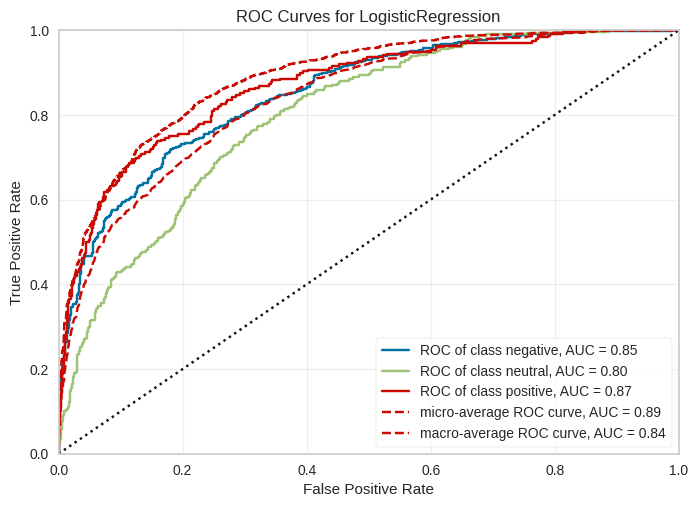

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [13]:
visualizer = ROCAUC(
    clf,
    classes=le.classes_,
    cmap='prism',
    linewidth=1.5
)

visualizer.fit(X_train_processed, y_train_processed)
visualizer.score(X_test_processed, y_test_processed)

plt.title("ROC Curves with Distinct Colors")
plt.grid(alpha=0.3)
visualizer.show()

### XGBoost

In [14]:
clf = XGBClassifier(n_estimators=100)
clf.fit(X_train_processed, y_train_processed)


y_train_pred = clf.predict(X_train_processed)
train_acc = np.mean(y_train_pred == y_train_processed)
print(f'Train set accuracy: {train_acc}')

y_test_pred = clf.predict(X_test_processed)
test_acc = np.mean(y_test_pred == y_test_processed)
print(f'Test set accuracy: {test_accuracy}')

Train set accuracy: 0.8287037037037037
Test set accuracy: 0.7213114754098361


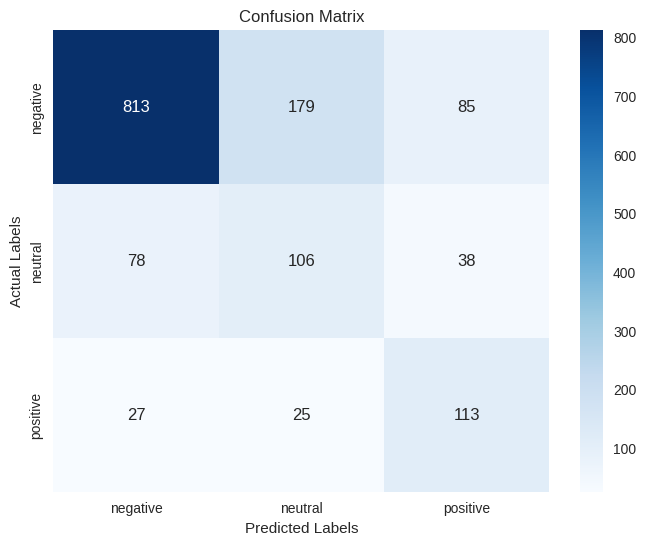

AUC (One-vs-Rest) on test data: 0.8337


In [15]:
cm = confusion_matrix(y_test_pred, y_test_processed)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


y_test_prob = clf.predict_proba(X_test_processed)
auc = roc_auc_score(y_test_processed, y_test_prob, multi_class='ovr')
print(f"AUC (One-vs-Rest) on test data: {auc:.4f}")


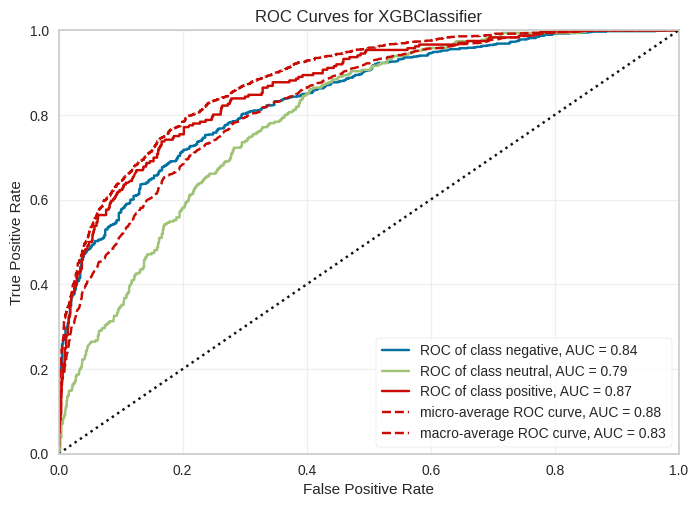

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [16]:
visualizer = ROCAUC(
    clf,
    classes=le.classes_,
    colors='prism',
    linewidth=1.5
)

visualizer.fit(X_train_processed, y_train_processed)
visualizer.score(X_test_processed, y_test_processed)

plt.title("ROC Curves with Distinct Colors")
plt.grid(alpha=0.3)
visualizer.show()

### Neural Network

In [17]:
X_train_processed_t = torch.tensor(X_train_processed.toarray(), dtype=torch.float32)
X_test_processed_t = torch.tensor(X_test_processed.toarray(), dtype=torch.float32)

ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = torch.tensor(ohe.fit_transform(y_train), dtype=torch.float32)
y_test_ohe = torch.tensor(ohe.transform(y_test), dtype=torch.float32)

le = LabelEncoder()
y_train_labels = le.fit_transform(y_train.values.flatten())
y_test_labels = le.transform(y_test.values.flatten())

In [18]:
class FNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fnn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        x = self.fnn(x)
        return x

In [19]:
path = './results'
model_path = os.path.join(path, 'best_model.pt')
def fit_neural_network(
        model, optimizer, criterion,
        X: npt.NDArray, y: npt.NDArray,
        epochs: int, batch_size: int
    ):
    
    n_batches = np.ceil(len(X) / batch_size).astype(np.int32)
    max_acc = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"epoch {epoch+1}/{epochs}")
        permutation_idx = torch.randperm(X.size(0))
        X_shuffled = X[permutation_idx]
        y_shuffled = y[permutation_idx]

        running_loss = 0.0
        for i in range(0, X.size(0), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
            f1s = f1_score(y_test_labels, y_pred, average='weighted')
            acc = accuracy_score(y_test_labels, y_pred)
            print(f"f1: {f1s:.3f}\tacc: {acc:.3f}")
            if acc > max_acc:
                max_acc = acc
                # if os.path.exists(model_path):
                    # print('exists')
                    # os.remove(model_path)
                # if error with pickle happens here, upgrade to python 3.13
                torch.save(model, model_path)
            running_loss = 0

In [20]:
model = FNN(X_train_processed_t.shape[1], 3)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [21]:
fit_neural_network(model, optimizer, criterion, X_train_processed_t, y_train_ohe, epochs=500, batch_size=128)

epoch 1/500
f1: 0.483	acc: 0.627
epoch 2/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.483	acc: 0.627
epoch 3/500
f1: 0.483	acc: 0.627
epoch 4/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.483	acc: 0.627
epoch 5/500
f1: 0.483	acc: 0.627
epoch 6/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.483	acc: 0.627
epoch 7/500
f1: 0.483	acc: 0.627
epoch 8/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.483	acc: 0.627
epoch 9/500
f1: 0.483	acc: 0.627
epoch 10/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.491	acc: 0.630
epoch 11/500
f1: 0.521	acc: 0.643
epoch 12/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.543	acc: 0.654
epoch 13/500
f1: 0.568	acc: 0.667
epoch 14/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.579	acc: 0.676
epoch 15/500
f1: 0.589	acc: 0.681
epoch 16/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.592	acc: 0.683
epoch 17/500
f1: 0.591	acc: 0.682
epoch 18/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.596	acc: 0.684
epoch 19/500
f1: 0.615	acc: 0.688
epoch 20/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.631	acc: 0.695
epoch 21/500
f1: 0.647	acc: 0.702
epoch 22/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.668	acc: 0.713
epoch 23/500
f1: 0.676	acc: 0.714
epoch 24/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.679	acc: 0.713
epoch 25/500
f1: 0.688	acc: 0.717
epoch 26/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.692	acc: 0.720
epoch 27/500
f1: 0.693	acc: 0.719
epoch 28/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.694	acc: 0.721
epoch 29/500
f1: 0.695	acc: 0.722
epoch 30/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.700	acc: 0.723
epoch 31/500
f1: 0.699	acc: 0.723
epoch 32/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.699	acc: 0.725
epoch 33/500
f1: 0.700	acc: 0.722
epoch 34/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.703	acc: 0.724
epoch 35/500
f1: 0.706	acc: 0.726
epoch 36/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.706	acc: 0.725
epoch 37/500
f1: 0.705	acc: 0.727
epoch 38/500
f1: 0.707	acc: 0.726
epoch 39/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.706	acc: 0.724
epoch 40/500
f1: 0.707	acc: 0.725
epoch 41/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.727
epoch 42/500
f1: 0.708	acc: 0.725
epoch 43/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.708	acc: 0.726
epoch 44/500
f1: 0.712	acc: 0.727
epoch 45/500
f1: 0.711	acc: 0.727
epoch 46/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.710	acc: 0.726
epoch 47/500
f1: 0.712	acc: 0.726
epoch 48/500
f1: 0.710	acc: 0.726
epoch 49/500
f1: 0.712	acc: 0.727
epoch 50/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.728
epoch 51/500
f1: 0.712	acc: 0.726
epoch 52/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.725
epoch 53/500
f1: 0.711	acc: 0.725
epoch 54/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.712	acc: 0.725
epoch 55/500
f1: 0.711	acc: 0.724
epoch 56/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.711	acc: 0.725
epoch 57/500
f1: 0.710	acc: 0.724
epoch 58/500
f1: 0.709	acc: 0.722
epoch 59/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.711	acc: 0.725
epoch 60/500
f1: 0.709	acc: 0.722
epoch 61/500
f1: 0.710	acc: 0.723
epoch 62/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.711	acc: 0.723
epoch 63/500
f1: 0.709	acc: 0.721
epoch 64/500
f1: 0.709	acc: 0.721
epoch 65/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.721
epoch 66/500
f1: 0.712	acc: 0.726
epoch 67/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.709	acc: 0.721
epoch 68/500
f1: 0.708	acc: 0.721
epoch 69/500
f1: 0.714	acc: 0.729
epoch 70/500
f1: 0.713	acc: 0.723
epoch 71/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.708	acc: 0.721
epoch 72/500
f1: 0.711	acc: 0.722
epoch 73/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.722
epoch 74/500
f1: 0.711	acc: 0.723
epoch 75/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 76/500
f1: 0.714	acc: 0.725
epoch 77/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.725
epoch 78/500
f1: 0.712	acc: 0.723
epoch 79/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 80/500
f1: 0.714	acc: 0.724
epoch 81/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.725
epoch 82/500
f1: 0.713	acc: 0.723
epoch 83/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 84/500
f1: 0.715	acc: 0.725
epoch 85/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 86/500
f1: 0.713	acc: 0.724
epoch 87/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.722
epoch 88/500
f1: 0.714	acc: 0.725
epoch 89/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.725
epoch 90/500
f1: 0.714	acc: 0.727
epoch 91/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.724
epoch 92/500
f1: 0.713	acc: 0.725
epoch 93/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 94/500
f1: 0.713	acc: 0.724
epoch 95/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.725
epoch 96/500
f1: 0.715	acc: 0.725
epoch 97/500
f1: 0.715	acc: 0.723
epoch 98/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.726
epoch 99/500
f1: 0.715	acc: 0.727
epoch 100/500
f1: 0.717	acc: 0.727
epoch 101/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.728
epoch 102/500
f1: 0.715	acc: 0.727
epoch 103/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.719	acc: 0.730
epoch 104/500
f1: 0.717	acc: 0.725
epoch 105/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.727
epoch 106/500
f1: 0.718	acc: 0.727
epoch 107/500
f1: 0.716	acc: 0.728
epoch 108/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.719	acc: 0.728
epoch 109/500
f1: 0.719	acc: 0.728
epoch 110/500
f1: 0.718	acc: 0.727
epoch 111/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.723
epoch 112/500
f1: 0.715	acc: 0.725
epoch 113/500
f1: 0.714	acc: 0.723
epoch 114/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.719	acc: 0.729
epoch 115/500
f1: 0.716	acc: 0.724
epoch 116/500
f1: 0.716	acc: 0.726
epoch 117/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 118/500
f1: 0.717	acc: 0.727
epoch 119/500
f1: 0.714	acc: 0.723
epoch 120/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.725
epoch 121/500
f1: 0.715	acc: 0.723
epoch 122/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.725
epoch 123/500
f1: 0.716	acc: 0.727
epoch 124/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.724
epoch 125/500
f1: 0.716	acc: 0.725
epoch 126/500
f1: 0.714	acc: 0.723
epoch 127/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.712	acc: 0.722
epoch 128/500
f1: 0.714	acc: 0.725
epoch 129/500
f1: 0.714	acc: 0.723
epoch 130/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.725
epoch 131/500
f1: 0.714	acc: 0.723
epoch 132/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.723
epoch 133/500
f1: 0.716	acc: 0.724
epoch 134/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.725
epoch 135/500
f1: 0.714	acc: 0.723
epoch 136/500
f1: 0.713	acc: 0.723
epoch 137/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.724
epoch 138/500
f1: 0.717	acc: 0.725
epoch 139/500
f1: 0.715	acc: 0.723
epoch 140/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.723
epoch 141/500
f1: 0.717	acc: 0.725
epoch 142/500
f1: 0.717	acc: 0.725
epoch 143/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.724
epoch 144/500
f1: 0.718	acc: 0.727
epoch 145/500
f1: 0.714	acc: 0.723
epoch 146/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.725
epoch 147/500
f1: 0.716	acc: 0.724
epoch 148/500
f1: 0.717	acc: 0.726
epoch 149/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.725
epoch 150/500
f1: 0.712	acc: 0.722
epoch 151/500
f1: 0.712	acc: 0.721
epoch 152/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.712	acc: 0.722
epoch 153/500
f1: 0.716	acc: 0.725
epoch 154/500
f1: 0.716	acc: 0.725
epoch 155/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 156/500
f1: 0.716	acc: 0.725
epoch 157/500
f1: 0.716	acc: 0.725
epoch 158/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.718	acc: 0.726
epoch 159/500
f1: 0.717	acc: 0.726
epoch 160/500
f1: 0.713	acc: 0.723
epoch 161/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.726
epoch 162/500
f1: 0.713	acc: 0.723
epoch 163/500
f1: 0.718	acc: 0.727
epoch 164/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.725
epoch 165/500
f1: 0.716	acc: 0.725
epoch 166/500
f1: 0.717	acc: 0.726
epoch 167/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.723
epoch 168/500
f1: 0.716	acc: 0.725
epoch 169/500
f1: 0.712	acc: 0.723
epoch 170/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.724
epoch 171/500
f1: 0.711	acc: 0.718
epoch 172/500
f1: 0.715	acc: 0.725
epoch 173/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.711	acc: 0.720
epoch 174/500
f1: 0.716	acc: 0.725
epoch 175/500
f1: 0.713	acc: 0.721
epoch 176/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.711	acc: 0.722
epoch 177/500
f1: 0.714	acc: 0.722
epoch 178/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.724
epoch 179/500
f1: 0.714	acc: 0.723
epoch 180/500
f1: 0.714	acc: 0.723
epoch 181/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.711	acc: 0.720
epoch 182/500
f1: 0.714	acc: 0.723
epoch 183/500
f1: 0.712	acc: 0.720
epoch 184/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.723
epoch 185/500
f1: 0.714	acc: 0.723
epoch 186/500
f1: 0.714	acc: 0.723
epoch 187/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 188/500
f1: 0.713	acc: 0.722
epoch 189/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.723
epoch 190/500
f1: 0.710	acc: 0.719
epoch 191/500
f1: 0.714	acc: 0.723
epoch 192/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 193/500
f1: 0.714	acc: 0.725
epoch 194/500
f1: 0.712	acc: 0.723
epoch 195/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.724
epoch 196/500
f1: 0.713	acc: 0.723
epoch 197/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.723
epoch 198/500
f1: 0.715	acc: 0.724
epoch 199/500
f1: 0.713	acc: 0.723
epoch 200/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.723
epoch 201/500
f1: 0.712	acc: 0.723
epoch 202/500
f1: 0.713	acc: 0.723
epoch 203/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.724
epoch 204/500
f1: 0.712	acc: 0.723
epoch 205/500
f1: 0.711	acc: 0.720
epoch 206/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.712	acc: 0.721
epoch 207/500
f1: 0.712	acc: 0.723
epoch 208/500
f1: 0.709	acc: 0.719
epoch 209/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.718
epoch 210/500
f1: 0.712	acc: 0.722
epoch 211/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.719
epoch 212/500
f1: 0.710	acc: 0.720
epoch 213/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 214/500
f1: 0.714	acc: 0.724
epoch 215/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 216/500
f1: 0.713	acc: 0.723
epoch 217/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.719
epoch 218/500
f1: 0.711	acc: 0.720
epoch 219/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 220/500
f1: 0.713	acc: 0.723
epoch 221/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.720
epoch 222/500
f1: 0.710	acc: 0.720
epoch 223/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.723
epoch 224/500
f1: 0.712	acc: 0.723
epoch 225/500
f1: 0.713	acc: 0.725
epoch 226/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.713	acc: 0.724
epoch 227/500
f1: 0.714	acc: 0.725
epoch 228/500
f1: 0.713	acc: 0.723
epoch 229/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.726
epoch 230/500
f1: 0.712	acc: 0.721
epoch 231/500
f1: 0.712	acc: 0.722
epoch 232/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.723
epoch 233/500
f1: 0.713	acc: 0.723
epoch 234/500
f1: 0.715	acc: 0.726
epoch 235/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.714	acc: 0.723
epoch 236/500
f1: 0.715	acc: 0.725
epoch 237/500
f1: 0.712	acc: 0.721
epoch 238/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 239/500
f1: 0.712	acc: 0.722
epoch 240/500
f1: 0.715	acc: 0.724
epoch 241/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.727
epoch 242/500
f1: 0.716	acc: 0.727
epoch 243/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.730
epoch 244/500
f1: 0.715	acc: 0.724
epoch 245/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.725
epoch 246/500
f1: 0.715	acc: 0.725
epoch 247/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.727
epoch 248/500
f1: 0.715	acc: 0.727
epoch 249/500
f1: 0.715	acc: 0.727
epoch 250/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.725
epoch 251/500
f1: 0.716	acc: 0.727
epoch 252/500
f1: 0.713	acc: 0.725
epoch 253/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.717	acc: 0.727
epoch 254/500
f1: 0.715	acc: 0.727
epoch 255/500
f1: 0.711	acc: 0.723
epoch 256/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.724
epoch 257/500
f1: 0.715	acc: 0.725
epoch 258/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.715	acc: 0.725
epoch 259/500
f1: 0.717	acc: 0.727
epoch 260/500
f1: 0.717	acc: 0.729
epoch 261/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.716	acc: 0.726
epoch 262/500
f1: 0.710	acc: 0.723
epoch 263/500
f1: 0.717	acc: 0.727
epoch 264/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 265/500
f1: 0.716	acc: 0.726
epoch 266/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.723
epoch 267/500
f1: 0.716	acc: 0.727
epoch 268/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.725
epoch 269/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.726
epoch 270/500
f1: 0.713	acc: 0.723
epoch 271/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.725
epoch 272/500
f1: 0.714	acc: 0.725
epoch 273/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.725
epoch 274/500
f1: 0.715	acc: 0.725
epoch 275/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.728
epoch 276/500
f1: 0.713	acc: 0.723
epoch 277/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.718	acc: 0.727
epoch 278/500
f1: 0.716	acc: 0.725
epoch 279/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.724
epoch 280/500
f1: 0.716	acc: 0.726
epoch 281/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 282/500
f1: 0.713	acc: 0.724
epoch 283/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.723
epoch 284/500
f1: 0.715	acc: 0.726
epoch 285/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.724
epoch 286/500
f1: 0.715	acc: 0.725
epoch 287/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.726
epoch 288/500
f1: 0.713	acc: 0.723
epoch 289/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 290/500
f1: 0.712	acc: 0.723
epoch 291/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.724
epoch 292/500
f1: 0.714	acc: 0.724
epoch 293/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.727
epoch 294/500
f1: 0.714	acc: 0.725
epoch 295/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.722
epoch 296/500
f1: 0.715	acc: 0.727
epoch 297/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.716	acc: 0.725
epoch 298/500
f1: 0.713	acc: 0.724
epoch 299/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 300/500
f1: 0.714	acc: 0.726
epoch 301/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 302/500
f1: 0.715	acc: 0.725
epoch 303/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.725
epoch 304/500
f1: 0.713	acc: 0.724
epoch 305/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 306/500
f1: 0.717	acc: 0.727
epoch 307/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.717	acc: 0.728
epoch 308/500
f1: 0.713	acc: 0.724
epoch 309/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.726
epoch 310/500
f1: 0.711	acc: 0.721
epoch 311/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 312/500
f1: 0.712	acc: 0.724
epoch 313/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 314/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 315/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 316/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 317/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 318/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.724
epoch 319/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 320/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 321/500
f1: 0.713	acc: 0.723
epoch 322/500
f1: 0.711	acc: 0.723
epoch 323/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 324/500
f1: 0.708	acc: 0.721
epoch 325/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 326/500
f1: 0.709	acc: 0.721
epoch 327/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.724
epoch 328/500
f1: 0.709	acc: 0.721
epoch 329/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 330/500
f1: 0.710	acc: 0.722
epoch 331/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype

f1: 0.712	acc: 0.723
epoch 332/500
f1: 0.709	acc: 0.721
epoch 333/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 334/500
f1: 0.713	acc: 0.724
epoch 335/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.722
epoch 336/500
f1: 0.712	acc: 0.723
epoch 337/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.724
epoch 338/500
f1: 0.708	acc: 0.720
epoch 339/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 340/500
f1: 0.712	acc: 0.723
epoch 341/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.707	acc: 0.718
epoch 342/500
f1: 0.712	acc: 0.722
epoch 343/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.726
epoch 344/500
f1: 0.707	acc: 0.720
epoch 345/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.722
epoch 346/500
f1: 0.712	acc: 0.724
epoch 347/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.721
epoch 348/500
f1: 0.716	acc: 0.726
epoch 349/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 350/500
f1: 0.713	acc: 0.725
epoch 351/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.722
epoch 352/500
f1: 0.710	acc: 0.723
epoch 353/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.724
epoch 354/500
f1: 0.715	acc: 0.726
epoch 355/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.715	acc: 0.726
epoch 356/500
f1: 0.715	acc: 0.726
epoch 357/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.725
epoch 358/500
f1: 0.710	acc: 0.722
epoch 359/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.724
epoch 360/500
f1: 0.717	acc: 0.728
epoch 361/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 362/500
f1: 0.711	acc: 0.724
epoch 363/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.723
epoch 364/500
f1: 0.710	acc: 0.723
epoch 365/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 366/500
f1: 0.712	acc: 0.724
epoch 367/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.721
epoch 368/500
f1: 0.717	acc: 0.728
epoch 369/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 370/500
f1: 0.711	acc: 0.725
epoch 371/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 372/500
f1: 0.710	acc: 0.723
epoch 373/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.725
epoch 374/500
f1: 0.710	acc: 0.723
epoch 375/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.721
epoch 376/500
f1: 0.711	acc: 0.723
epoch 377/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 378/500
f1: 0.713	acc: 0.725
epoch 379/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.708	acc: 0.721
epoch 380/500
f1: 0.711	acc: 0.723
epoch 381/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 382/500
f1: 0.710	acc: 0.723
epoch 383/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.723
epoch 384/500
f1: 0.708	acc: 0.721
epoch 385/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.722
epoch 386/500
f1: 0.709	acc: 0.720
epoch 387/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.725
epoch 388/500
f1: 0.711	acc: 0.723
epoch 389/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 390/500
f1: 0.710	acc: 0.723
epoch 391/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.708	acc: 0.721
epoch 392/500
f1: 0.710	acc: 0.723
epoch 393/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 394/500
f1: 0.710	acc: 0.722
epoch 395/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 396/500
f1: 0.710	acc: 0.723
epoch 397/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.724
epoch 398/500
f1: 0.708	acc: 0.720
epoch 399/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.722
epoch 400/500
f1: 0.710	acc: 0.723
epoch 401/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.724
epoch 402/500
f1: 0.709	acc: 0.721
epoch 403/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 404/500
f1: 0.710	acc: 0.723
epoch 405/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 406/500
f1: 0.709	acc: 0.721
epoch 407/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.722
epoch 408/500
f1: 0.709	acc: 0.721
epoch 409/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 410/500
f1: 0.710	acc: 0.723
epoch 411/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.723
epoch 412/500
f1: 0.708	acc: 0.723
epoch 413/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.722
epoch 414/500
f1: 0.710	acc: 0.723
epoch 415/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.723
epoch 416/500
f1: 0.711	acc: 0.723
epoch 417/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.721
epoch 418/500
f1: 0.710	acc: 0.721
epoch 419/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.721
epoch 420/500
f1: 0.710	acc: 0.721
epoch 421/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.708	acc: 0.719
epoch 422/500
f1: 0.708	acc: 0.721
epoch 423/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 424/500
f1: 0.709	acc: 0.722
epoch 425/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.724
epoch 426/500
f1: 0.709	acc: 0.722
epoch 427/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.723
epoch 428/500
f1: 0.709	acc: 0.723
epoch 429/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 430/500
f1: 0.707	acc: 0.720
epoch 431/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.708	acc: 0.721
epoch 432/500
f1: 0.708	acc: 0.721
epoch 433/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.708	acc: 0.721
epoch 434/500
f1: 0.707	acc: 0.721
epoch 435/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.707	acc: 0.721
epoch 436/500
f1: 0.708	acc: 0.720
epoch 437/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.727
epoch 438/500
f1: 0.709	acc: 0.722
epoch 439/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 440/500
f1: 0.713	acc: 0.725
epoch 441/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 442/500
f1: 0.713	acc: 0.725
epoch 443/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.721
epoch 444/500
f1: 0.712	acc: 0.725
epoch 445/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.726
epoch 446/500
f1: 0.714	acc: 0.725
epoch 447/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.726
epoch 448/500
f1: 0.711	acc: 0.723
epoch 449/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 450/500
f1: 0.710	acc: 0.723
epoch 451/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 452/500
f1: 0.710	acc: 0.725
epoch 453/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 454/500
f1: 0.711	acc: 0.723
epoch 455/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.714	acc: 0.727
epoch 456/500
f1: 0.712	acc: 0.725
epoch 457/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.724
epoch 458/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.725
epoch 459/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 460/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.724
epoch 461/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.713	acc: 0.725
epoch 462/500
f1: 0.708	acc: 0.721
epoch 463/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 464/500
f1: 0.710	acc: 0.723
epoch 465/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 466/500
f1: 0.711	acc: 0.723
epoch 467/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.725
epoch 468/500
f1: 0.711	acc: 0.723
epoch 469/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 470/500
f1: 0.707	acc: 0.719
epoch 471/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.708	acc: 0.721
epoch 472/500
f1: 0.708	acc: 0.720
epoch 473/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.708	acc: 0.721
epoch 474/500
f1: 0.710	acc: 0.723
epoch 475/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 476/500
f1: 0.712	acc: 0.725
epoch 477/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 478/500
f1: 0.711	acc: 0.723
epoch 479/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.722
epoch 480/500
f1: 0.710	acc: 0.723
epoch 481/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.725
epoch 482/500
f1: 0.707	acc: 0.719
epoch 483/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 484/500
f1: 0.709	acc: 0.721
epoch 485/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.725
epoch 486/500
f1: 0.709	acc: 0.722
epoch 487/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.724
epoch 488/500
f1: 0.710	acc: 0.724
epoch 489/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 490/500
f1: 0.712	acc: 0.726
epoch 491/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.709	acc: 0.722
epoch 492/500
f1: 0.712	acc: 0.726
epoch 493/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.711	acc: 0.723
epoch 494/500
f1: 0.709	acc: 0.723
epoch 495/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.710	acc: 0.723
epoch 496/500
f1: 0.711	acc: 0.725
epoch 497/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.725
epoch 498/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.727
epoch 499/500


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


f1: 0.712	acc: 0.724
epoch 500/500
f1: 0.712	acc: 0.725


/tmp/ipykernel_46267/2153364932.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))


In [ ]:
model = torch.load(model_path, weights_only=False)
model.eval()
y_pred = np.array(torch.argmax(model(X_test_processed_t), dim=1))
nn_acc = accuracy_score(y_test_labels, y_pred)
nn_f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f'Neural Network Accuracy: {nn_acc}')
print(f'Neural Network F1-score: {nn_f1}')

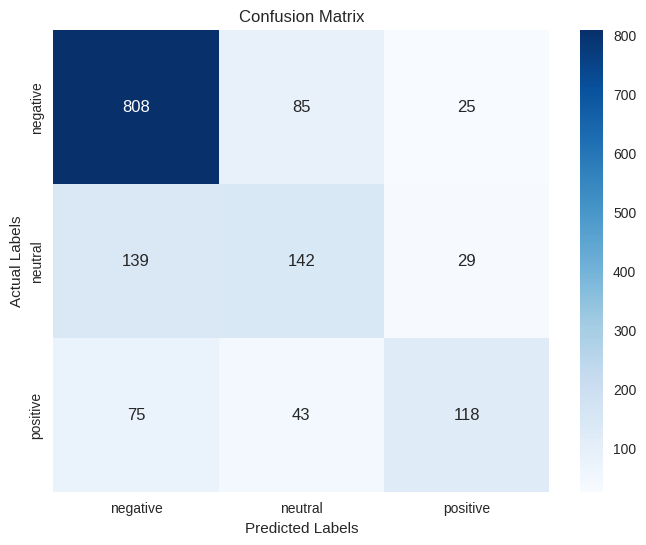

In [23]:
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

/tmp/ipykernel_46267/231785274.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train_pred = np.array(torch.argmax(y_train_pred, dim=1))
/tmp/ipykernel_46267/231785274.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_test_pred = np.array(torch.argmax(y_test_pred, dim=1))


Accuracy on training data: 0.7818
Accuracy on test data: 0.7295

Classification report for the test data:
              precision    recall  f1-score   support

    negative       0.79      0.88      0.83       918
     neutral       0.53      0.46      0.49       310
    positive       0.69      0.50      0.58       236

    accuracy                           0.73      1464
   macro avg       0.67      0.61      0.63      1464
weighted avg       0.72      0.73      0.72      1464



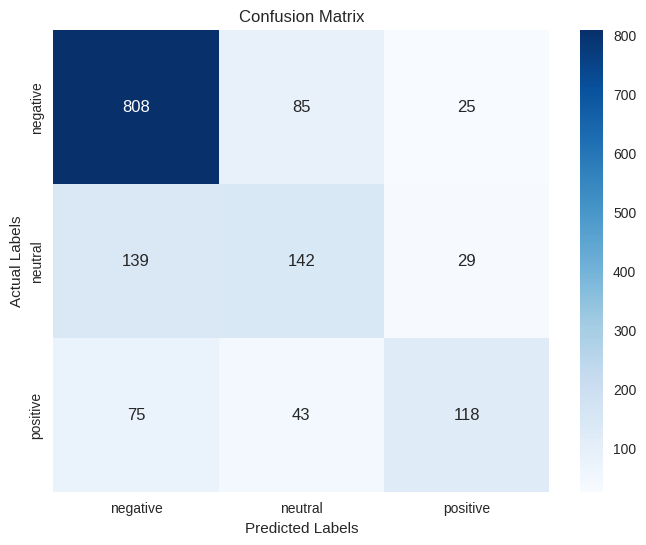

In [24]:
y_train_pred = model(X_train_processed_t)
y_train_pred = np.array(torch.argmax(y_train_pred, dim=1))

train_accuracy = accuracy_score(y_train_labels, y_train_pred)
print(f"Accuracy on training data: {train_accuracy:.4f}")

y_test_pred = model(X_test_processed_t)
y_test_pred = np.array(torch.argmax(y_test_pred, dim=1))
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Accuracy on test data: {test_accuracy:.4f}")
print("\nClassification report for the test data:")
print(classification_report(y_test_labels, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_labels, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


In [25]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_processed_t) 

y_pred_probs = y_pred_probs.cpu().numpy()  
num_classes = 3
y_test_onehot = label_binarize(y_test_labels, classes=[0, 1, 2])  
auc_ovr_weighted = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="weighted")
print("Weighted One-vs-Rest AUC:", auc_ovr_weighted)

gini_ovr_weighted = 2 * auc_ovr_weighted - 1
print("Gini:", gini_ovr_weighted)

auc_per_class = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average=None)
gini_per_class = 2 * auc_per_class - 1
for i, (auc_val, gini_val) in enumerate(zip(auc_per_class, gini_per_class)):
    print(f"Class {i}: AUC={auc_val:.3f}, Gini={gini_val:.3f}")

Weighted One-vs-Rest AUC: 0.8353563712827055
Gini: 0.6707127425654109
Class 0: AUC=0.847, Gini=0.693
Class 1: AUC=0.784, Gini=0.567
Class 2: AUC=0.860, Gini=0.719


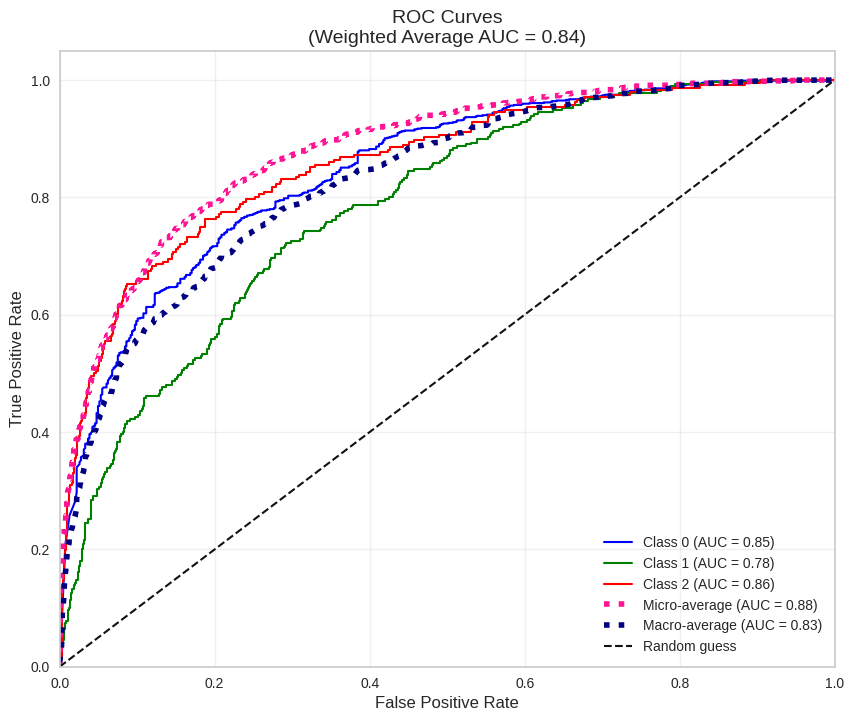

In [26]:
num_classes = 3

fpr = dict()
tpr = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
auc_micro = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="micro")

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
auc_macro = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="macro")

auc_ovr_weighted = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="weighted")

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'Class {i} (AUC = {auc_per_class[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {auc_micro:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {auc_macro:.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curves\n(Weighted Average AUC = {auc_ovr_weighted:.2f})', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [27]:
del model

# Stage 4: Comparison with LLM Models (e.g., OpenAI)

**Goal**: Compare the results of custom-built models with those from LLM (Large Language Models).

**Tasks**:

1. **Developing an LLM Prompt**:
   - Create an effective prompt for sentiment analysis. Example:
     ```
     Analyze the sentiment of the following text and classify it as positive, negative, or neutral:
     "{text}"
     ```

2. **Using LLM API**:
   - Send test data to the LLM model via API.
   - Save LLM model predictions.
   - Ensure compliance with LLM usage policies.

3. **Analysis and Comparison of Results**:
   - Compare evaluation metrics of all models.
   - Identify differences in predictions between models.
   - Discuss potential reasons for these differences:
     - Ability to understand context.
     - Handling irony or sarcasm.
     - Impact of input data quality.

---

In [28]:
# Stage 4
import sys
!{sys.executable} -m pip install transformers
!{sys.executable} -m pip install transformers[sentencepiece]
!{sys.executable} -m pip install openai google-generativeai transformers torch seaborn

  Using cached sentencepiece-0.2.0.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [98 lines of output]
      /home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/setuptools/_distutils/dist.py:270: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build/lib.linux-x86_64-cpython-313/sentencepiece
      copying src/sentencepiece/__init__.py -> build/lib.linux-x86_64-cpython-313/sentencepiece
      copying src/sentencepiece/_version.py -> build/lib.linux-x86_64-cpython-313/sentencepiece
      copying src/sentencepiece/sentencepiece_model_pb2.py -> build/lib.linux-x86_64-cpython-313/sentencepiece
      copying src/sentencepiece/sentencepiece_pb2.py -> build/lib.linux-x86_64-cpython-313/sentencepiece
      running build_ext
      Package s

In [33]:
import openai
import google.generativeai as genai
from transformers import pipeline

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay  
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

import src.prompt_llm as prompt_llm

In [30]:
openai_key = input("Enter your OpenAI API key (or press Enter to skip and load precomputed CSV): ")
gemini_key = input("Enter your Gemini API key (or press Enter to skip and load precomputed CSV): ")

if openai_key:
    openai.api_key = openai_key
    openai_client = openai.OpenAI(api_key=openai_key)

if gemini_key:
    genai.configure(api_key=gemini_key)
    gemini_model = genai.GenerativeModel('gemini-1.5-flash')

roberta_classifier = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    top_k=None
)

deberta_classifier = pipeline(
    "zero-shot-classification",
    model="sileod/deberta-v3-base-tasksource-nli"
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0


In [39]:
csv_name = 'results/model_comparison.csv'

if openai_key and gemini_key:
    results = []
    for i in tqdm(range(len(X_test))):
        # if i == 10:
            # break
        row = X_test.iloc[i]
        text = row['text']
        
        prompt = f"""Analyze the sentiment of this text. Respond ONLY with one word: positive, negative, or neutral. No punctuation. Text: {text}"""

        deberta_pred = deberta_classifier(text, ['positive', 'negative', 'neutral'])
        deberta_final = deberta_pred['labels'][np.argmax(deberta_pred['scores'])]
        deberta_probs = {
            'deberta_positive': deberta_pred['scores'][0],
            'deberta_negative': deberta_pred['scores'][1],
            'deberta_neutral': deberta_pred['scores'][2]
        }
        
        try: gpt_pred = prompt_llm.get_gpt_sentiment(openai_client, prompt)
        except: gpt_pred = "error"
        
        try: gemini_pred = prompt_llm.get_gemini_sentiment(gemini_model, prompt)
        except: gemini_pred = "error"
        
        roberta_pred = prompt_llm.get_roberta_sentiment(roberta_classifier, text)
        roberta_probs = {}
        roberta_preds = roberta_classifier(text)[0]
        for pred in roberta_preds:
            label = pred['label'].lower()
            roberta_probs[f'roberta_{label}'] = pred['score']
        
        results.append({
            'text': text,
            'deberta': deberta_final,
            'gpt': gpt_pred,
            'gemini': gemini_pred,
            'roberta': roberta_pred,
            'deberta_positive': deberta_probs['deberta_positive'],
            'deberta_negative': deberta_probs['deberta_negative'],
            'deberta_neutral': deberta_probs['deberta_neutral'],
            'roberta_positive': roberta_probs.get('roberta_positive', 0),
            'roberta_negative': roberta_probs.get('roberta_negative', 0),
            'roberta_neutral': roberta_probs.get('roberta_neutral', 0),
                })
        
    results_df = pd.DataFrame(results)
    results_df.to_csv(csv_name, index=False)
else:
    print("One or both of the API keys missing. Loading data from CSV...")
    results_df = pd.read_csv(csv_name)

print(results_df.head())

100%|██████████| 1464/1464 [21:55<00:00,  1.11it/s]

                                                text   deberta       gpt  \
0  @united at its worse. Can't figure how to pack...  negative  negative   
1  “@USAirways: @ch_mom Please reach out to our c...  negative   neutral   
2  @SouthwestAir Pres/CEO Gary Kelly at #TheRoFo ...  positive   neutral   
3  @USAirways its fine. \n\nJust wondering where ...   neutral  negative   
4  @USAirways trying 2 fly frm DCA to SRQ to visi...  negative  negative   

     gemini   roberta  deberta_positive  deberta_negative  deberta_neutral  \
0  negative  negative          0.870505          0.081026         0.048469   
1   neutral  negative          0.447852          0.425024         0.127123   
2   neutral   neutral          0.368076          0.316620         0.315304   
3  negative   neutral          0.522265          0.320916         0.156819   
4  negative  negative          0.660794          0.196728         0.142477   

   roberta_positive  roberta_negative  roberta_neutral  
0          0.0044

In [40]:
y_true = y_test
print(results_df['deberta'])
print("DeBERTa Report:")
print(classification_report(y_true, results_df['deberta']))

print("\nGPT-3.5 Report:")
print(classification_report(y_true, results_df['gpt']))

print("\nGemini Report:")
print(classification_report(y_true, results_df['gemini']))

print("\nRoberta Report:")
print(classification_report(y_true, results_df['roberta']))

0       negative
1       negative
2       positive
3        neutral
4       negative
          ...   
1459    negative
1460    negative
1461    positive
1462    positive
1463    negative
Name: deberta, Length: 1464, dtype: object
DeBERTa Report:
              precision    recall  f1-score   support

    negative       0.86      0.90      0.88       918
     neutral       0.55      0.07      0.12       310
    positive       0.48      0.94      0.64       236

    accuracy                           0.73      1464
   macro avg       0.63      0.64      0.55      1464
weighted avg       0.73      0.73      0.68      1464


GPT-3.5 Report:
              precision    recall  f1-score   support

    negative       0.95      0.86      0.90       918
     neutral       0.62      0.73      0.67       310
    positive       0.76      0.83      0.79       236

    accuracy                           0.83      1464
   macro avg       0.77      0.81      0.79      1464
weighted avg       0.85      0

/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michal/miniconda3/envs/jup/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1400x800 with 0 Axes>

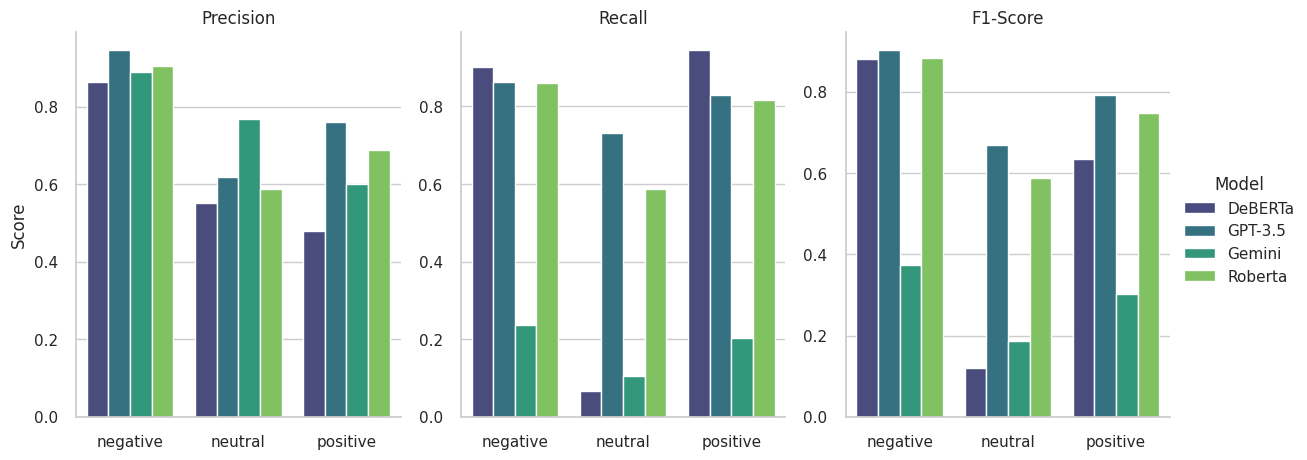

In [46]:
EXCLUDED_CLASSES = {'accuracy', 'macro avg', 'weighted avg', 'error', 'nostalgic', 'mixed'}

def get_report_dict(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True, zero_division=0)

reports = {
    'DeBERTa': get_report_dict(y_true, results_df['deberta']),
    'GPT-3.5': get_report_dict(y_true, results_df['gpt']),
    'Gemini': get_report_dict(y_true, results_df['gemini']),
    'Roberta': get_report_dict(y_true, results_df['roberta'])
}

metrics_data = []
for model_name, report in reports.items():
    for class_name, metrics in report.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg', 'error', 'nostalgic', 'mixed']:
            continue
        metrics_data.append({
            'Model': model_name,
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score'],
            'Support': metrics['support']
        })

df = pd.DataFrame(metrics_data)

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

melted_df = df.melt(id_vars=['Model', 'Class'], 
                    value_vars=['Precision', 'Recall', 'F1-Score'],
                    var_name='Metric')

g = sns.catplot(
    data=melted_df,
    x='Class', y='value', hue='Model',
    col='Metric', kind='bar',
    height=5, aspect=0.8,
    palette='viridis',
    sharey=False
)

g.set_axis_labels("", "Score")
g.set_titles("{col_name}")
accuracy_data = {model: report['accuracy'] for model, report in reports.items()}
accuracy_df = pd.DataFrame([accuracy_data]).T.reset_index()
accuracy_df.columns = ['Model', 'Accuracy']


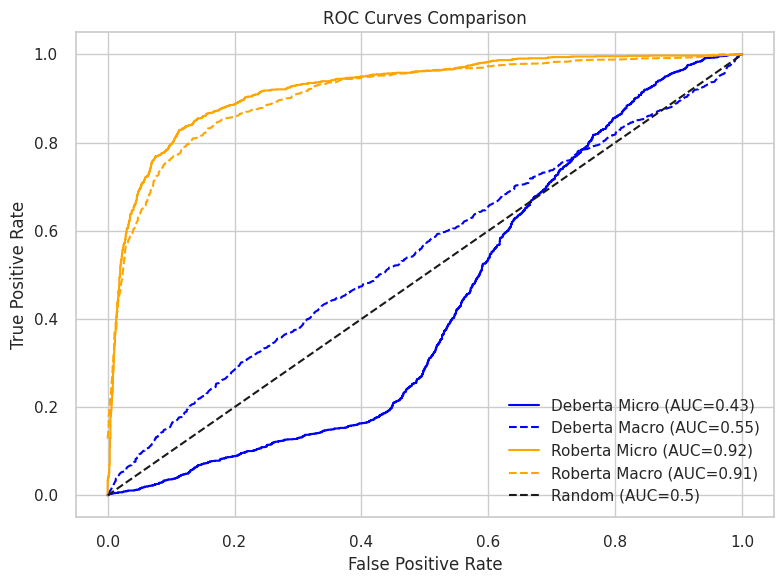

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# DeBERTa/RoBERTa - Micro/Macro
for model in ['deberta', 'roberta']:
    color = 'blue' if model == 'deberta' else 'orange'
    
    micro_probs = np.vstack([results_df[f'{model}_{cls}'] for cls in classes]).T.ravel()
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), micro_probs)
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, 
             color=color, linestyle='-', 
             label=f'{model.title()} Micro (AUC={auc_micro:.2f})')

    fprs, tprs = [], []
    for cls in classes:
        fpr, tpr, _ = roc_curve(y_true_bin[:, classes.index(cls)], results_df[f'{model}_{cls}'])
        fprs.append(fpr)
        tprs.append(tpr)
    
    all_fpr = np.unique(np.concatenate(fprs))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fprs[i], tprs[i])
    mean_tpr /= len(classes)
    auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, 
             color=color, linestyle='--', 
             label=f'{model.title()} Macro (AUC={auc_macro:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()